In [8]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [9]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
data_directory = './data/lunar/training/data/S12_GradeA/'

WINDOW_SIZE = 8000
STEP_SIZE = 2000
MEAN_AMPLITUDE_FACTOR = 1.1
MAX_AMPLITUDE_DEVIATION = 80

cat = pd.read_csv(cat_file)

In [10]:
# Power, bandwidth, spectral entropy, peak frequency, dominant frequency, centroid frequency, mean frequency and spectral amplitude

def get_power(dataframe):
    # The power of a signal is the sum of the squares of the absolute values of the signal's time-domain samples divided by the signal length
    data = dataframe.data

    return np.sum(np.abs(data)**2)

def get_bandwidth(dataframe):
    # The bandwidth of a signal is the range of frequencies that it contains
    data = dataframe.data
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft)**2)

def get_highest_amplitude(dataframe):
    data = dataframe.data

    return np.max(np.abs(data))

def get_lowest_amplitude(dataframe):
    data = dataframe.data

    return np.min(np.abs(data))

def get_spectral_entropy(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)
    power = np.abs(fft)**2
    power = power / np.sum(power)  # Normalización
    power = power[power > 0]  # Evitar log(0)

    return -np.sum(power * np.log(power))

def get_spectral_amplitude(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)

    return np.max(np.abs(fft))

def get_mean_amplitude(dataframe):
    data = dataframe.data

    return np.mean(np.abs(data))

def get_characteristics(dataframe):
    return dict(
        # power=get_power(dataframe),
        # bandwidth=get_bandwidth(dataframe),
        mean_amplitude=get_mean_amplitude(dataframe),
        # spectral_entropy=get_spectral_entropy(dataframe),
        spectral_amplitude=get_spectral_amplitude(dataframe)
    )

def get_file_data(file: str):
    data = pd.read_csv(file)

    csv_times = np.array(data['time_rel(sec)'].tolist())
    csv_data = np.array(data['velocity(m/s)'].tolist())

    return pd.DataFrame(dict(
        time=csv_times,
        data=csv_data
    ))

def get_file_data_from_catalog(index: int):
    catalog_row = cat.iloc[index]

    filename = catalog_row.filename

    csv_file = f'{data_directory}{filename}.csv'
    data_cat = pd.read_csv(csv_file)

    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())

    return pd.DataFrame(dict(
        time=csv_times,
        data=csv_data
    ))

def get_windowed_data(dataframe, offset=0, window_size=WINDOW_SIZE):
    result = []
    data = dataframe.data
    times = dataframe.time

    for i in range(offset, offset + window_size):
        if i >= len(data):
            break

        row = dict(
            time=times[i],
            data=data[i]
        )
        result.append(row)
    
    return pd.DataFrame(result)

def get_windows_characteristics(windows):
    characteristics = []

    for i in range(len(windows)):
        window = windows[i]

        characteristics.append(get_characteristics(window))
        print(f'Processed window {i}/{len(windows)}')

    return pd.DataFrame(characteristics)

def get_start_event_window(dataframe):
    max_spectral_amplitude = float('-inf')
    max_spectral_amplitude_index = 0

    dataframe_mean_amplitude = get_characteristics(dataframe)['mean_amplitude']

    for offset in range(0, len(dataframe), STEP_SIZE):
        window = get_windowed_data(dataframe, offset)
        characteristics = get_characteristics(window)

        if characteristics['spectral_amplitude'] > max_spectral_amplitude:
            min_max_amplitude_difference = np.abs(get_highest_amplitude(window) - get_lowest_amplitude(window))
            deviation_coefficient =  min_max_amplitude_difference / dataframe_mean_amplitude

            if deviation_coefficient > MAX_AMPLITUDE_DEVIATION:
                continue

            max_spectral_amplitude = characteristics['spectral_amplitude']
            max_spectral_amplitude_index = offset
    
    # Go back 1 windows to get the start of the event
    max_spectral_amplitude_index -= 2 * STEP_SIZE
    
    return get_windowed_data(dataframe, max_spectral_amplitude_index), max_spectral_amplitude_index

def get_end_event_window(dataframe, event_window_index):
    # Starting in the event time, get the first window that its mean amplitude is less than the mean amplitude of the event window

    window_mean_amplitude = get_characteristics(dataframe)['mean_amplitude'] * MEAN_AMPLITUDE_FACTOR

    for i in range(event_window_index, len(dataframe), STEP_SIZE):
        window = get_windowed_data(dataframe, i, WINDOW_SIZE)
        mean_amplitude = get_mean_amplitude(window)

        if mean_amplitude < window_mean_amplitude:
            return window, i

    return None, None

def get_event_dataframe(dataframe):
    _, start_event_window_index = get_start_event_window(dataframe)
    _, end_event_window_index = get_end_event_window(dataframe, start_event_window_index)

    result = dataframe.iloc[start_event_window_index:end_event_window_index]

    return result

def get_noiseless_data_from_file(file: str):
    data = get_file_data(file)

    return get_event_dataframe(data)

def remove_noise_from_file(file: str):
    data = get_file_data(file)
    event_data = get_event_dataframe(data)
    final_file = file.split('/')[-1]

    detect_df = pd.DataFrame(data = {
        "filename": [final_file for _ in range(len(event_data))],
        "time_rel(sec)": event_data.time,
        "velocity(m/s)": event_data.data
    })

    detect_df.to_csv(file.replace('.csv', '_NOISELESS.csv'), index=False)

In [11]:
def plot_test(index):
    file_index = index
    dataframe = get_file_data_from_catalog(file_index)

    start_event_window, start_event_window_index = get_start_event_window(dataframe)
    end_event_window, end_event_window_index = get_end_event_window(dataframe, start_event_window_index)

    print(f'Start event window: {start_event_window_index}')
    print(f'End event window: {end_event_window_index}')
    times = dataframe.time
    data = dataframe.data

    # plot
    fig, ax = plt.subplots(1,1,figsize=(10,3))
    ax.plot(times, data)

    event_mean_amplitude = get_mean_amplitude(end_event_window)
    event_start_time = start_event_window.time.iloc[0]
    event_end_time = end_event_window.time.iloc[0]

    # Shadow the event window
    ax.axvspan(event_start_time, event_end_time, color='green', alpha=0.5)

    # Plot event mean amplitude
    ax.axhline(event_mean_amplitude, color='r', linestyle='--', label=f'Event mean amplitude ({event_mean_amplitude:.2f})')

    # Make the plot pretty
    ax.set_xlim([min(times), max(times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'File index {index}', fontweight='bold')


    # Plot where the event window is
    event_window_times = dataframe.time[start_event_window_index:end_event_window_index]
    event_window_data = dataframe.data[start_event_window_index:end_event_window_index]
    event_window_line = ax.plot(event_window_times, event_window_data, c='purple', label=f'Event window (mean amplitude: {event_mean_amplitude:.2f})')
    ax.legend(handles=event_window_line)

    plt.show()

Start event window: 484000
End event window: 560000


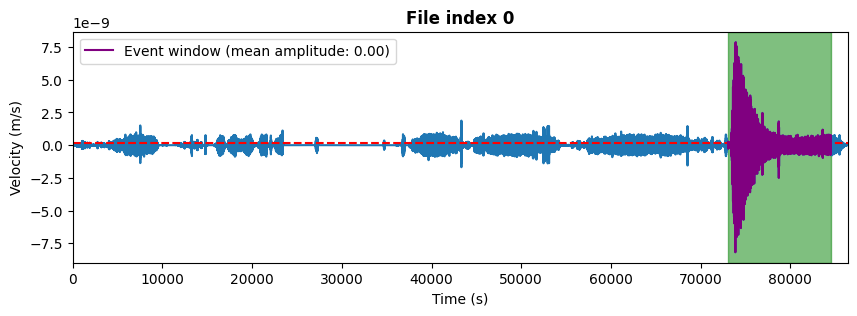

                time          data
484000  73056.603774  1.160719e-10
484001  73056.754717 -1.045790e-10
484002  73056.905660 -1.057214e-10
484003  73057.056604 -1.068639e-10
484004  73057.207547 -1.080063e-10
...              ...           ...
559995  84527.547170  2.655994e-10
559996  84527.698113  1.889065e-10
559997  84527.849057 -5.614459e-11
559998  84528.000000 -2.783637e-10
559999  84528.150943 -2.912981e-10

[76000 rows x 2 columns]
Start event window: 82000
End event window: 102000


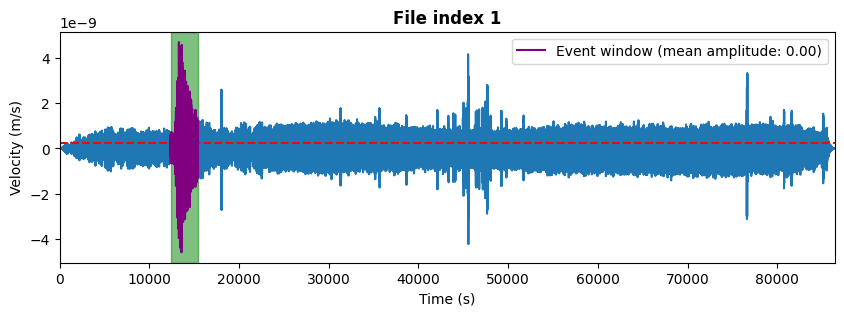

                time          data
82000   12377.358491 -7.828698e-11
82001   12377.509434  3.212836e-10
82002   12377.660377  6.018278e-10
82003   12377.811321  6.129399e-10
82004   12377.962264  3.804165e-10
...              ...           ...
101995  15395.471698 -6.309699e-11
101996  15395.622642 -5.068669e-10
101997  15395.773585 -6.871275e-10
101998  15395.924528 -6.356738e-10
101999  15396.075472 -4.642372e-10

[20000 rows x 2 columns]
Start event window: 480000
End event window: 508000


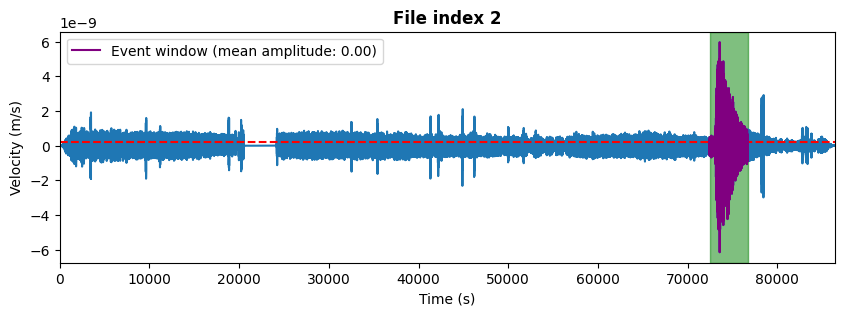

                time          data
480000  72452.830189 -2.591507e-10
480001  72452.981132 -3.077435e-10
480002  72453.132075 -2.499700e-10
480003  72453.283019 -1.023596e-10
480004  72453.433962  6.426345e-11
...              ...           ...
507995  76678.490566 -1.090277e-10
507996  76678.641509 -1.001359e-10
507997  76678.792453 -2.531158e-10
507998  76678.943396 -5.176155e-10
507999  76679.094340 -7.189753e-10

[28000 rows x 2 columns]
Start event window: 26000
End event window: 60000


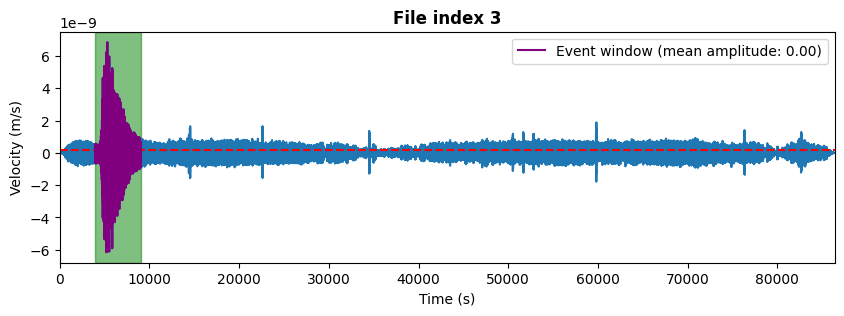

              time          data
26000  3924.528302  1.273916e-10
26001  3924.679245  1.502900e-10
26002  3924.830189  1.639893e-10
26003  3924.981132  1.785754e-10
26004  3925.132075  1.852245e-10
...            ...           ...
59995  9055.849057  3.496721e-10
59996  9056.000000  3.385986e-10
59997  9056.150943  1.931116e-10
59998  9056.301887  5.356868e-12
59999  9056.452830 -1.313705e-10

[34000 rows x 2 columns]
Start event window: 342000
End event window: 392000


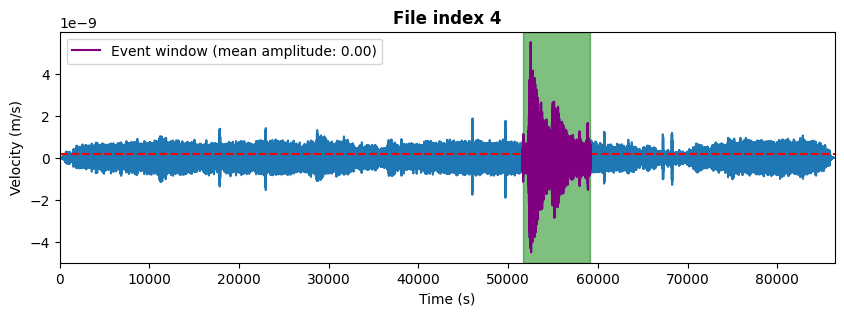

                time          data
342000  51622.641509 -5.660838e-10
342001  51622.792453 -3.240742e-10
342002  51622.943396  8.529021e-11
342003  51623.094340  4.070740e-10
342004  51623.245283  4.569991e-10
...              ...           ...
391995  59169.056604 -7.433620e-11
391996  59169.207547 -7.964761e-11
391997  59169.358491 -4.478925e-11
391998  59169.509434 -1.867339e-11
391999  59169.660377 -2.430156e-11

[50000 rows x 2 columns]
Start event window: 454000
End event window: 480000


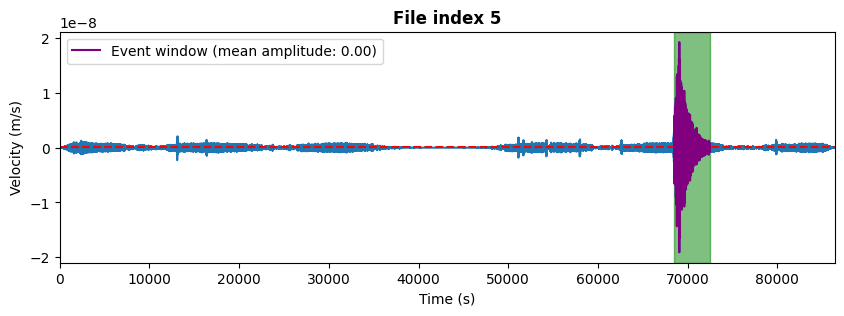

                time          data
454000  68528.301887  1.543404e-09
454001  68528.452830  9.538425e-10
454002  68528.603774 -6.244589e-11
454003  68528.754717 -7.039940e-10
454004  68528.905660 -5.591362e-10
...              ...           ...
479995  72452.075472  2.499960e-10
479996  72452.226415  3.715671e-10
479997  72452.377358  3.916028e-10
479998  72452.528302  3.001436e-10
479999  72452.679245  1.225665e-10

[26000 rows x 2 columns]
Start event window: 482000
End event window: 512000


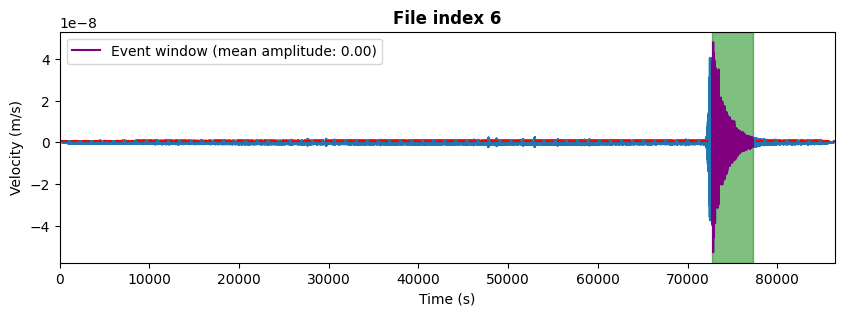

                time          data
482000  72754.716981  2.693974e-09
482001  72754.867925  2.026728e-08
482002  72755.018868  2.630150e-08
482003  72755.169811  1.960196e-08
482004  72755.320755  7.277670e-09
...              ...           ...
511995  77282.264151 -5.845553e-10
511996  77282.415094 -4.740114e-10
511997  77282.566038 -2.514613e-10
511998  77282.716981 -6.295754e-11
511999  77282.867925  3.137485e-11

[30000 rows x 2 columns]
Start event window: 118000
End event window: 162000


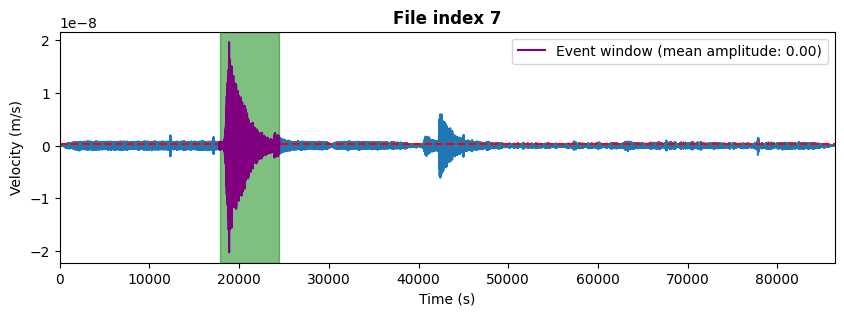

                time          data
118000  17811.320755  3.673997e-11
118001  17811.471698  7.857490e-11
118002  17811.622642  2.299009e-11
118003  17811.773585 -2.052317e-11
118004  17811.924528  3.462260e-11
...              ...           ...
161995  24452.075472 -1.056353e-09
161996  24452.226415 -8.959426e-10
161997  24452.377358 -3.488797e-10
161998  24452.528302  1.799545e-10
161999  24452.679245  3.963180e-10

[44000 rows x 2 columns]
Start event window: 118000
End event window: 162000


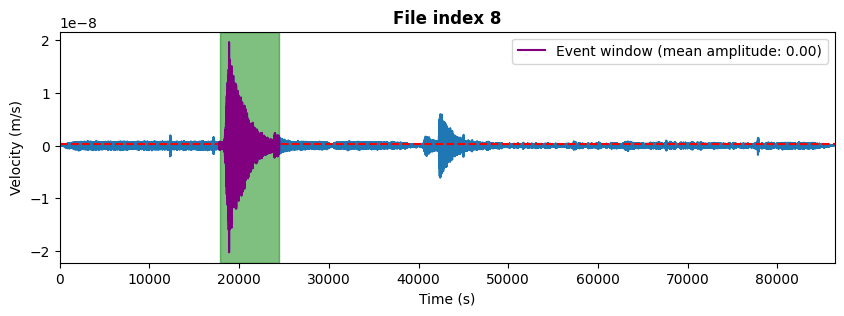

                time          data
118000  17811.320755  3.673997e-11
118001  17811.471698  7.857490e-11
118002  17811.622642  2.299009e-11
118003  17811.773585 -2.052317e-11
118004  17811.924528  3.462260e-11
...              ...           ...
161995  24452.075472 -1.056353e-09
161996  24452.226415 -8.959426e-10
161997  24452.377358 -3.488797e-10
161998  24452.528302  1.799545e-10
161999  24452.679245  3.963180e-10

[44000 rows x 2 columns]
Start event window: 472000
End event window: 510000


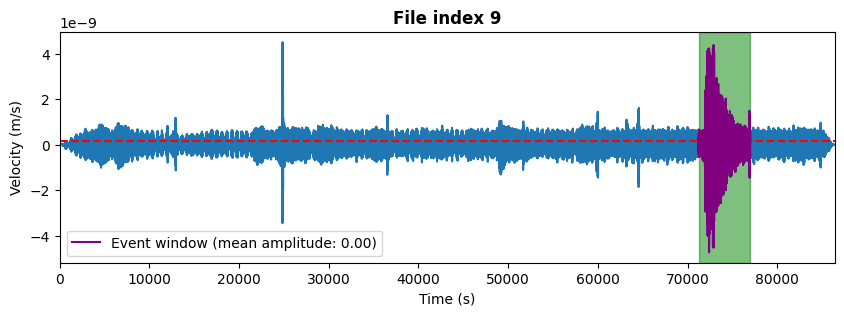

                time          data
472000  71245.283019 -1.300203e-10
472001  71245.433962 -1.473559e-10
472002  71245.584906 -1.978860e-10
472003  71245.735849 -2.985653e-10
472004  71245.886792 -3.991570e-10
...              ...           ...
509995  76980.377358  1.730884e-10
509996  76980.528302  2.486484e-10
509997  76980.679245  5.990221e-11
509998  76980.830189 -2.560328e-10
509999  76980.981132 -4.715861e-10

[38000 rows x 2 columns]
Start event window: 472000
End event window: 488000


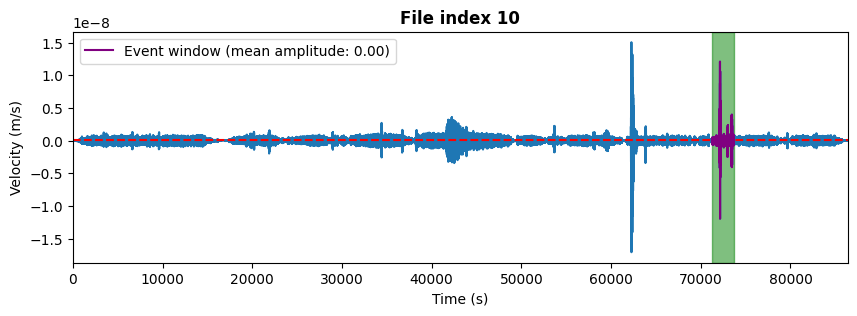

                time          data
472000  71245.283019 -2.121086e-10
472001  71245.433962  1.827422e-10
472002  71245.584906  1.841254e-10
472003  71245.735849  1.855086e-10
472004  71245.886792  1.868917e-10
...              ...           ...
487995  73659.622642  8.535288e-11
487996  73659.773585  9.913195e-11
487997  73659.924528 -5.657975e-11
487998  73660.075472 -2.717491e-10
487999  73660.226415 -3.905282e-10

[16000 rows x 2 columns]
Start event window: 306000
End event window: 402000


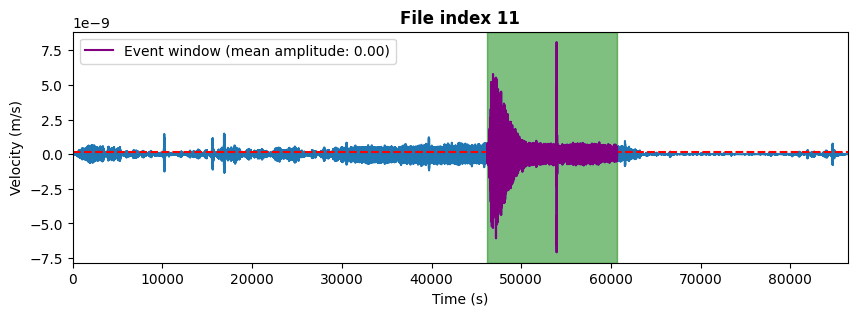

                time          data
306000  46188.679245  3.331747e-10
306001  46188.830189  2.554161e-10
306002  46188.981132  4.563927e-11
306003  46189.132075 -2.153470e-10
306004  46189.283019 -4.205423e-10
...              ...           ...
401995  60678.490566 -3.653226e-10
401996  60678.641509 -3.615780e-10
401997  60678.792453 -1.878810e-10
401998  60678.943396  1.209950e-11
401999  60679.094340  9.880157e-11

[96000 rows x 2 columns]
Start event window: 176000
End event window: 286000


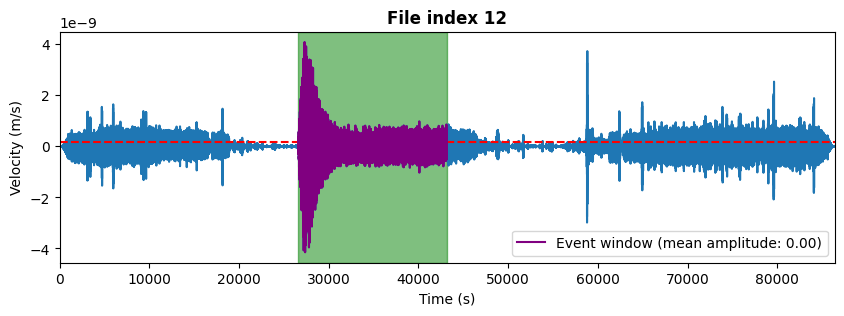

                time          data
176000  26566.037736 -1.603170e-13
176001  26566.188679 -2.735031e-13
176002  26566.339623 -2.933423e-13
176003  26566.490566 -2.093444e-13
176004  26566.641509 -9.870929e-14
...              ...           ...
285995  43169.056604  1.145553e-10
285996  43169.207547  2.228007e-11
285997  43169.358491 -1.469080e-10
285998  43169.509434 -2.944341e-10
285999  43169.660377 -3.444950e-10

[110000 rows x 2 columns]
Start event window: 488000
End event window: 516000


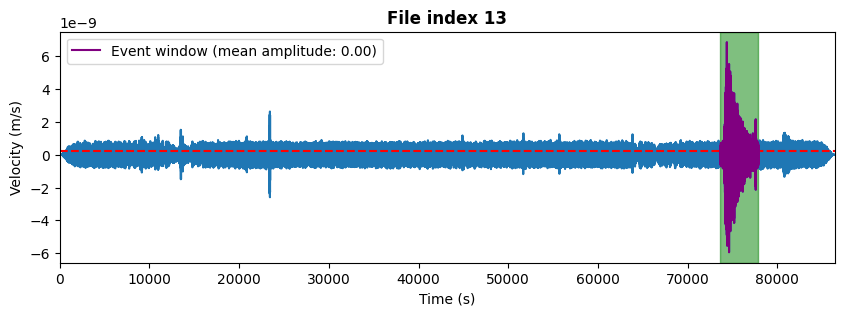

                time          data
488000  73660.377358 -2.009734e-10
488001  73660.528302 -3.361643e-10
488002  73660.679245 -3.622074e-10
488003  73660.830189 -2.538676e-10
488004  73660.981132 -5.604734e-11
...              ...           ...
515995  77886.037736 -6.882647e-11
515996  77886.188679 -5.143756e-11
515997  77886.339623 -2.009470e-11
515998  77886.490566  6.162517e-11
515999  77886.641509  1.790599e-10

[28000 rows x 2 columns]
Start event window: 366000
End event window: 390000


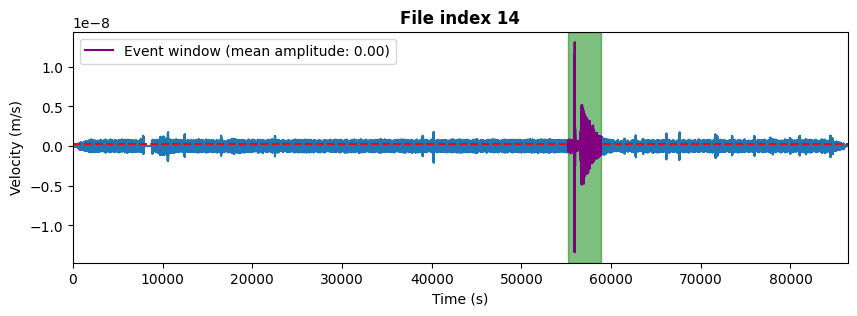

                time          data
366000  55245.283019  3.116337e-10
366001  55245.433962  1.660452e-10
366002  55245.584906 -1.522214e-11
366003  55245.735849 -1.338776e-10
366004  55245.886792 -1.287577e-10
...              ...           ...
389995  58867.169811  2.177199e-10
389996  58867.320755 -1.958721e-10
389997  58867.471698 -5.426028e-10
389998  58867.622642 -5.871055e-10
389999  58867.773585 -2.673377e-10

[24000 rows x 2 columns]
Start event window: 300000
End event window: 344000


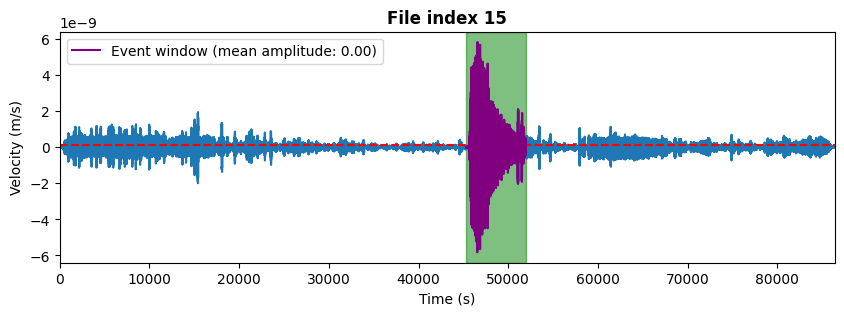

                time          data
300000  45283.018868  4.262733e-13
300001  45283.169811  1.037143e-13
300002  45283.320755  3.366812e-13
300003  45283.471698  1.216611e-12
300004  45283.622642  2.047352e-12
...              ...           ...
343995  51923.773585 -1.416630e-11
343996  51923.924528 -1.368021e-11
343997  51924.075472 -1.820373e-11
343998  51924.226415 -3.614622e-11
343999  51924.377358 -5.934301e-11

[44000 rows x 2 columns]
Start event window: 354000
End event window: 372000


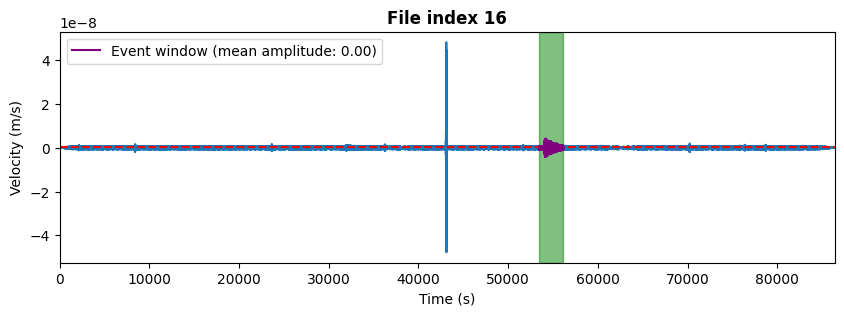

                time          data
354000  53433.962264 -5.124943e-10
354001  53434.113208 -3.541597e-11
354002  53434.264151  4.235227e-10
354003  53434.415094  5.818709e-10
354004  53434.566038  3.687048e-10
...              ...           ...
371995  56150.188679 -4.279469e-10
371996  56150.339623 -4.633614e-10
371997  56150.490566 -5.167385e-10
371998  56150.641509 -5.442717e-10
371999  56150.792453 -4.606970e-10

[18000 rows x 2 columns]
Start event window: 348000
End event window: 348000


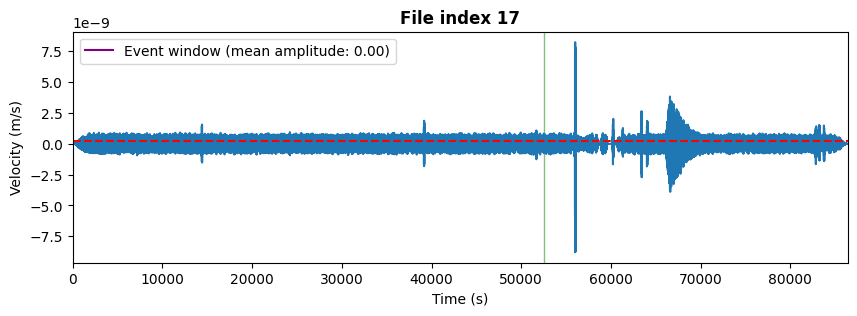

Empty DataFrame
Columns: [time, data]
Index: []
Start event window: 90000
End event window: 198000


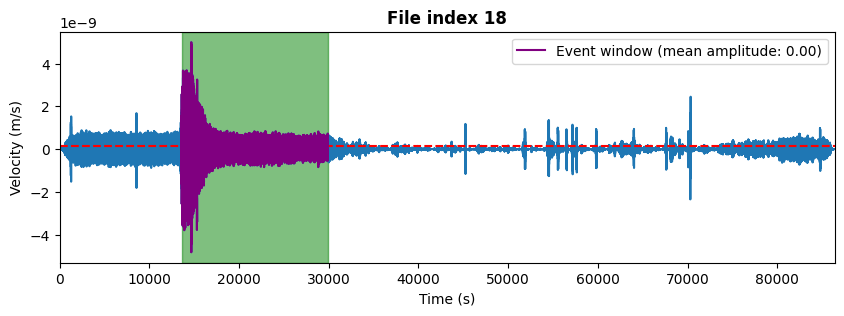

                time          data
90000   13584.905660  5.631183e-11
90001   13585.056604  1.782630e-10
90002   13585.207547 -1.144866e-10
90003   13585.358491 -5.890175e-10
90004   13585.509434 -8.142877e-10
...              ...           ...
197995  29886.037736 -8.915159e-11
197996  29886.188679  1.612562e-10
197997  29886.339623  3.055505e-10
197998  29886.490566  2.321675e-10
197999  29886.641509 -2.050073e-11

[108000 rows x 2 columns]
Start event window: 362000
End event window: 398000


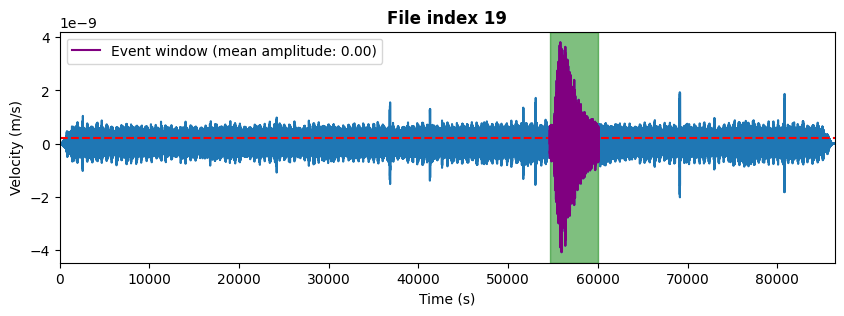

                time          data
362000  54641.509434  1.012889e-11
362001  54641.660377  4.940161e-11
362002  54641.811321  2.437812e-12
362003  54641.962264 -6.500546e-11
362004  54642.113208 -8.545674e-11
...              ...           ...
397995  60074.716981 -5.533118e-10
397996  60074.867925 -4.429959e-10
397997  60075.018868 -2.427459e-10
397998  60075.169811 -2.662205e-11
397999  60075.320755  1.438882e-10

[36000 rows x 2 columns]
Start event window: 244000
End event window: 294000


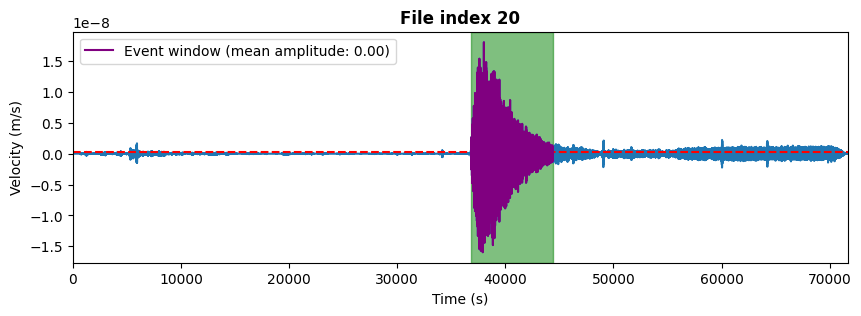

                time          data
244000  36830.188679 -8.507107e-10
244001  36830.339623 -8.001291e-10
244002  36830.490566 -4.588407e-10
244003  36830.641509 -2.890641e-11
244004  36830.792453  2.612672e-10
...              ...           ...
293995  44376.603774  2.431772e-10
293996  44376.754717  2.535742e-10
293997  44376.905660  1.825679e-10
293998  44377.056604  9.036061e-11
293999  44377.207547  3.286420e-11

[50000 rows x 2 columns]
Start event window: 172000
End event window: 206000


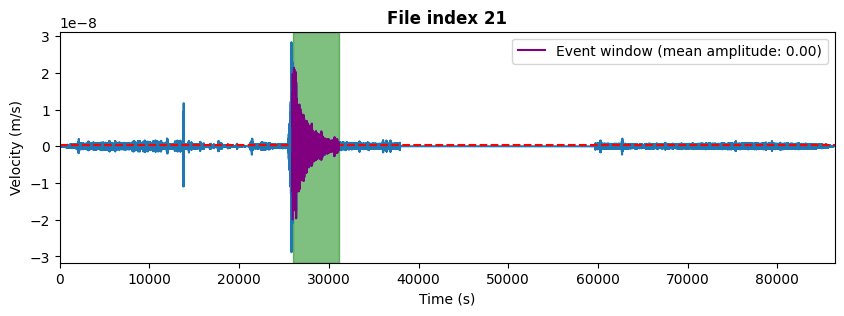

                time          data
172000  25962.264151 -1.984476e-08
172001  25962.415094 -1.876270e-09
172002  25962.566038  2.102202e-09
172003  25962.716981  6.080673e-09
172004  25962.867925  1.005914e-08
...              ...           ...
205995  31093.584906 -1.821869e-10
205996  31093.735849 -4.073962e-10
205997  31093.886792 -3.818430e-10
205998  31094.037736 -1.399066e-10
205999  31094.188679  1.229860e-10

[34000 rows x 2 columns]


KeyboardInterrupt: 

In [16]:
for n in range(0, 74):
    plot_test(n)

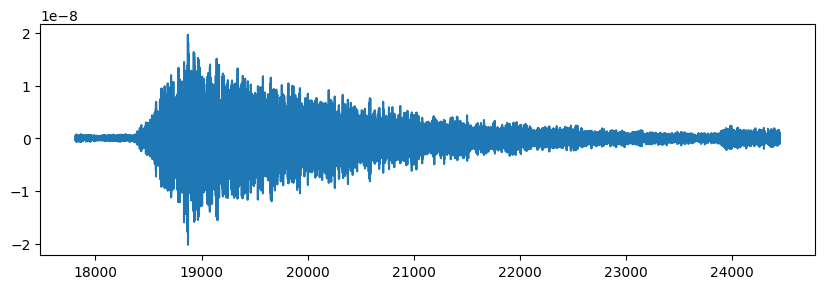

                time          data
118000  17811.320755  3.673997e-11
118001  17811.471698  7.857490e-11
118002  17811.622642  2.299009e-11
118003  17811.773585 -2.052317e-11
118004  17811.924528  3.462260e-11
...              ...           ...
161995  24452.075472 -1.056353e-09
161996  24452.226415 -8.959426e-10
161997  24452.377358 -3.488797e-10
161998  24452.528302  1.799545e-10
161999  24452.679245  3.963180e-10

[44000 rows x 2 columns]


In [13]:
dataframe = get_noiseless_data_from_file(f'{data_directory}{cat.iloc[8].filename}.csv')

fig, ax = plt.subplots(1,1,figsize=(10,3))
times = dataframe.time
data = dataframe.data

ax.plot(times, data)
plt.show()

print(dataframe)

In [15]:
get_noiseless_data_from_file(f'./data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.csv')

,time,data
484000,73056.603774,1.160719e-10
484001,73056.754717,-1.045790e-10
484002,73056.905660,-1.057214e-10
484003,73057.056604,-1.068639e-10
484004,73057.207547,-1.080063e-10
...,...,...
559995,84527.547170,2.655994e-10
559996,84527.698113,1.889065e-10
559997,84527.849057,-5.614459e-11
559998,84528.000000,-2.783637e-10
